Problem statement: A developer has contracted me to determine which building decisions offer the highest return.  I will examine the Ames housing data to try and arrive at factors of development that should be kept in mind as the developer seeks to effectively allocate capital and planning recourses.

Alternative:  From the developer or homeowner's perspective, when does building a pool add value net of cost?

In [1]:
#Imports
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error


data: http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

#### missing vals

##### missing vals resources

https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8#:~:text=When%20column%20has%20more%20than,%25%20missing%20value%2C%20drop%20it.

##### missing values analysis

In [2]:
df = pd.read_csv('../datasets/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [3]:
df.shape

(2051, 81)

In [4]:
df.isnull().sum()

# df.drop([i for i in df.isnull().sum() if i >] axis = 1)

Id                0
PID               0
MS SubClass       0
MS Zoning         0
Lot Frontage    330
               ... 
Misc Val          0
Mo Sold           0
Yr Sold           0
Sale Type         0
SalePrice         0
Length: 81, dtype: int64

In [5]:
df.isnull().sum().describe()

count      81.000000
mean      121.259259
std       425.600804
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      2042.000000
dtype: float64

In [6]:
df.isnull().sum()[df.isnull().sum()>0].quantile([x/100 for x in range(70,80)])

0.70    114.0
0.71    114.0
0.72    114.0
0.73    114.0
0.74    114.0
0.75    114.0
0.76    114.0
0.77    168.0
0.78    222.0
0.79    276.0
dtype: float64

Able to keep 76% of features if the null cutoff is 115 nulls.

In [7]:
[col for col in df.columns if col in df.isnull().sum()[df.isnull().sum()>115]]

['Lot Frontage', 'Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']

There are not many Misc Features.

In [47]:
df.loc[:, 'Misc Feature'].value_counts()

None    1986
Shed      56
Gar2       4
Othr       3
TenC       1
Elev       1
Name: Misc Feature, dtype: int64

Only 65 houses with misc features.  Shed is the most common of these with 56, but the median sale price is not much different (163_000.0 with no shed vs 153_750.0 with a shed)

In [56]:
df.loc[df['Misc Feature'].isna(), 'Misc Feature'] = "None"
df.groupby('Misc Feature')['SalePrice'].median()

Misc Feature
Elev    183850.0
Gar2    148500.0
None    163000.0
Othr    186000.0
Shed    153750.0
TenC    250000.0
Name: SalePrice, dtype: float64

In [37]:
df.loc[:,'Misc Feature'].value_counts()

Shed    56
Gar2     4
Othr     3
TenC     1
Elev     1
Name: Misc Feature, dtype: int64

Replace NAN for Fireplace Qu with 'None' where the num Fireplaces is 0.

In [13]:
df.loc[df['Fireplaces']==0,"Fireplace Qu"] = 'None'

Gd    4
Fa    2
TA    2
Ex    1
Name: Pool QC, dtype: int64

Note: there are so few pools (9) that it would be difficult to draw conclusions from columns 'Pool QC' and 'Pool Area'.  I will drop these features from  the dataset that will be used for further analysis.

In [26]:
df.drop(columns = ['Pool QC', 'Pool Area'], inplace = True)

Per the data dictionary, I will replace NaN values in the data dictionary with 'None' as these buildings do not have a fence.

In [34]:
df.loc[df['Fence'].isna(),'Fence']="None"

In [22]:
df.groupby('Pool QC').mean()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
Pool QC,,,,,,,,,,,,,,,,,,,,,
Ex,2231.00,9.094752e+08,20.0,70.0,18044.00,8.00,5.0,1986.00,1986.00,0.00,...,216.0,64.0,169.0,0.0,0.0,228.0,0.0,8.00,2007.0,315000.0
Fa,2354.50,5.273665e+08,40.0,79.0,13416.00,6.50,5.5,1976.00,1988.50,141.50,...,132.5,56.0,0.0,0.0,220.0,583.5,1000.0,4.00,2006.0,215500.0
Gd,2075.25,8.151329e+08,75.0,163.0,26946.75,7.25,5.5,1981.25,1981.25,235.25,...,411.0,157.0,0.0,0.0,0.0,648.5,0.0,4.25,2007.0,216492.5
TA,2110.00,7.292776e+08,20.0,137.5,26516.00,3.50,5.5,1953.00,1953.00,0.00,...,354.0,133.0,0.0,0.0,0.0,464.5,0.0,4.00,2007.0,141500.0


In [17]:
df['Pool Area']

0      2042
519       1
576       1
800       1
228       1
480       1
648       1
738       1
368       1
561       1
Name: Pool Area, dtype: int64

In [10]:
df['Fireplace Qu'].unique()

array([nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

0       False
1       False
2       False
3       False
4       False
        ...  
2046    False
2047    False
2048    False
2049    False
2050    False
Name: Fireplace Qu, Length: 2051, dtype: bool

In [8]:
df.Alley.isna().sum()

1911

In [9]:
pd.set_option('display.max_columns', None)
df.groupby("Alley").mean()
# group_by
df.Alley.unique()

array([nan, 'Pave', 'Grvl'], dtype=object)

In [27]:
df["Fireplace Qu"]

0       None
1         TA
2       None
3       None
4       None
        ... 
2046      Gd
2047    None
2048      TA
2049      Gd
2050      TA
Name: Fireplace Qu, Length: 2051, dtype: object

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

Below, I replace NaN in Fireplace Qu with "None"

In [26]:

df.loc[df['Fireplaces']==0,'Fireplace Qu'] = 'None'

In [10]:
df[df["Alley"].isna()==True].describe()


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [11]:
# I will replace Alley access to None instead of NA, per the data dictionary description

In [14]:
df.loc[df["Alley"].isna()==True, 'Alley'] = "None"

In [16]:
df.groupby('Alley').mean()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
Alley,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Grvl,1662.847059,8.473912e+08,64.411765,59.296296,8487.141176,5.058824,5.952941,1921.294118,1970.082353,6.058824,135.658824,29.411765,617.152941,782.223529,926.388235,471.811765,20.423529,1418.623529,0.164706,0.070588,1.329412,0.176471,2.952941,1.082353,6.505882,0.317647,1944.901408,1.317647,345.811765,54.517647,45.458824,76.847059,0.000000,19.858824,0.000000,86.470588,6.294118,2007.564706,120835.635294
None,1466.965986,7.097315e+08,55.251177,70.367527,10263.277342,6.141811,5.551544,1973.765568,1984.448456,103.171338,460.571728,49.702618,563.671204,1073.945550,1180.138148,318.648875,4.506018,1503.293040,0.441069,0.064955,1.582941,0.375196,2.848770,1.041340,6.451596,0.612245,1979.716492,1.795288,479.105759,97.488749,46.406593,19.966510,2.664050,16.475667,2.573522,51.506541,6.230246,2007.785453,184366.258503
Pave,1427.800000,6.408712e+08,106.636364,43.666667,5622.036364,6.709091,5.327273,1978.163636,1997.018182,125.867925,281.690909,16.072727,632.236364,930.000000,988.690909,480.218182,17.454545,1486.363636,0.363636,0.000000,1.763636,0.527273,2.490909,1.036364,5.781818,0.272727,1989.490566,1.836364,482.563636,27.600000,90.763636,29.218182,4.072727,12.581818,0.000000,0.000000,5.745455,2007.763636,174534.709091


In [ ]:
df

In [116]:
df.groupby("Alley")

<bound method GroupBy.mean of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7fce72d986a0>>

Dealing with null values

In [67]:
df['Lot Frontage'].isna().sum()

330

In [84]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False, handle_unknown="ignore")

In [86]:
ohe.fit_transform(df["Lot Config"])

ValueError: Expected 2D array, got 1D array instead:
array=['CulDSac' 'CulDSac' 'Inside' ... 'Inside' 'Corner' 'Inside'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [87]:
df.cols

AttributeError: 'DataFrame' object has no attribute 'cols'

In [ ]:
ctx = ColumnTransformer(
    transformers = [
        #('alias_first', actual_transformer, list_of_cols_to_apply_to)
        ('one_hot', ohe, ['Lot Config', 'Lot Shape', 'day', 'time'])
    ], remainder = 'passthrough', #don't drop the others
    verbose_feature_names_out = False
)

In [83]:
df['Lot Area'].isna().sum()

0

In [69]:
df['Lot Area'].describe()

count      2051.000000
mean      10065.208191
std        6742.488909
min        1300.000000
25%        7500.000000
50%        9430.000000
75%       11513.500000
max      159000.000000
Name: Lot Area, dtype: float64

In [79]:
df['Lot Config'].unique()

array(['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'], dtype=object)

In [ ]:
ohe

array(['CulDSac', 'Inside', 'Corner', 'FR2', 'FR3'], dtype=object)

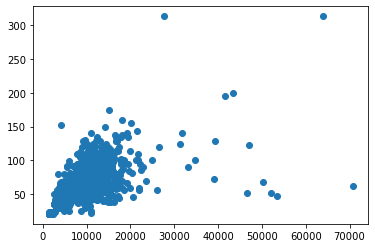

In [70]:
plt.scatter(x = df['Lot Area'], y = df['Lot Frontage'])
df["Lot Config"].unique()

idea: to get missing frontage values, regress the lot frontage on lot area, lot shape, and lot config

In [71]:
ohe = OneHotEncoder()

In [72]:
from sklearn.linear_model import LinearRegression

In [73]:
lr = LinearRegression()

In [ ]:
X_train_enc = pd.DataFrame(X_train_enc, columns = ctx.get_feature_names_out())
X_test_enc = pd.DataFrame(X_test_enc, columns = ctx.get_feature_names_out())

In [74]:
# one hot encoding explanation source:
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
# label_encoder = LabelEncoder()
# integer_encoded = label_encoder.fit_transform(values)
# print(integer_encoded)
# # binary encode
# onehot_encoder = OneHotEncoder(sparse=False)
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
# print(onehot_encoded)
# # invert first example
# inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
# print(inverted)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

onehot_encoded = onehot_encoder.fit_transform(df['MS SubClass'].values.reshape(1,-1))

print(onehot_encoded)

NameError: name 'onehot_encoder' is not defined

In [ ]:
sklearn.linear_model.LinearRegression(*, fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False)

In [ ]:
df.columns

In [ ]:
df['MS SubClass']

data_dictionary:

|Feature|Type|Dataset|Description|
|---|---|---|---|
|Id|object|test_df|The state to which the observations pertain|
|MS|float|test_df|Proportion of the state's 2017 HS graduates who took the ACT| 